<a href="https://colab.research.google.com/github/alyilmaz99/surface_crack_cnn_detect/blob/main/surface_crack_cnn_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile

from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing import image
from pathlib import Path

##https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

In [ ]:
! pip install -q kaggle

In [ ]:
!pip install -q opendatasets
import opendatasets as od

#od.download('https://www.kaggle.com/datasets/arunrk7/surface-crack-detection')



Skipping, found downloaded files in "./surface-crack-detection" (use force=True to force download)


In [ ]:
data_folder = '/content/surface-crack-detection/'

infected_folder = os.path.join(data_folder, 'Positive')
not_infected_folder = os.path.join(data_folder, 'Negative')



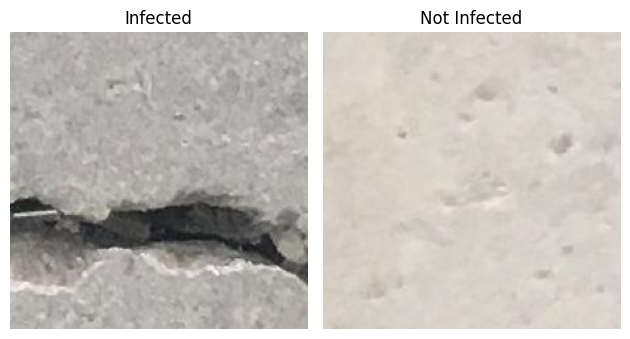

In [ ]:

sample_infected_image = Image.open(os.path.join(infected_folder, os.listdir(infected_folder)[1]))
sample_not_infected_image = Image.open(os.path.join(not_infected_folder, os.listdir(not_infected_folder)[1]))

plt.subplot(1, 2, 1)
plt.imshow(sample_infected_image)
plt.title("Infected")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_not_infected_image)
plt.title("Not Infected")
plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
infected_images = [os.path.join(infected_folder, img) for img in os.listdir(infected_folder)]
not_infected_images = [os.path.join(not_infected_folder, img) for img in os.listdir(not_infected_folder)]
labels_infected = [1] * len(infected_images)
labels_not_infected = [0] * len(not_infected_images)



In [ ]:
all_images = infected_images + not_infected_images
all_labels = labels_infected + labels_not_infected

In [ ]:

train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, shuffle=True
)


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


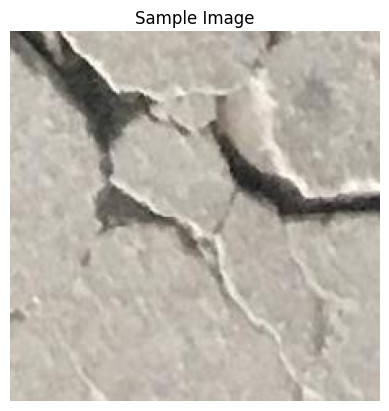

In [ ]:
sample_image = Image.open(train_images[0])
plt.imshow(sample_image)
plt.title("Sample Image")
plt.axis('off')
plt.show()

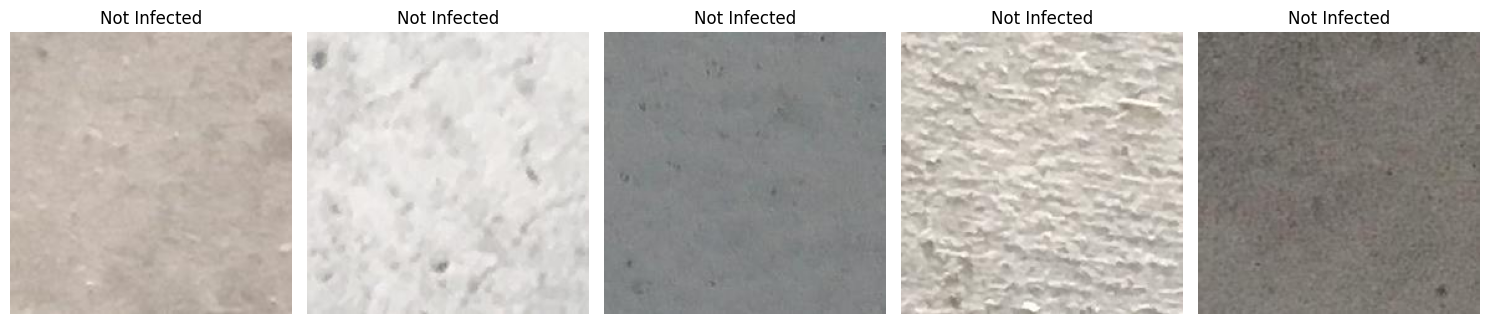

In [ ]:
not_infected_indices = [i for i, label in enumerate(train_labels) if label == 0]

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(Image.open(train_images[not_infected_indices[i]]))
    plt.title("Not Infected")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def create_dataset(image_paths, labels, image_size=(224, 224), batch_size=32):
    images = []
    for img_path, label in zip(image_paths, labels):
        img = Image.open(img_path).resize(image_size)
        img = np.array(img) / 255.0
        images.append(img)
        if len(images) == batch_size:
            yield np.array(images), np.array(labels[:len(images)])
            images = []

    if images:
        yield np.array(images), np.array(labels[:len(images)])



In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.6),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2)
])


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Epoch 1/50
1000/1000 [==============================] - 3959s 4s/step - loss: 0.6916 - accuracy: 0.5302 - val_loss: 0.6967 - val_accuracy: 0.4062
Epoch 2/50


1000/1000 [==============================] - 0s 139us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


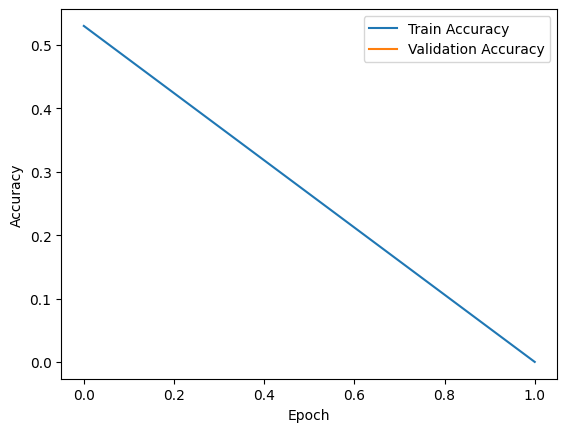

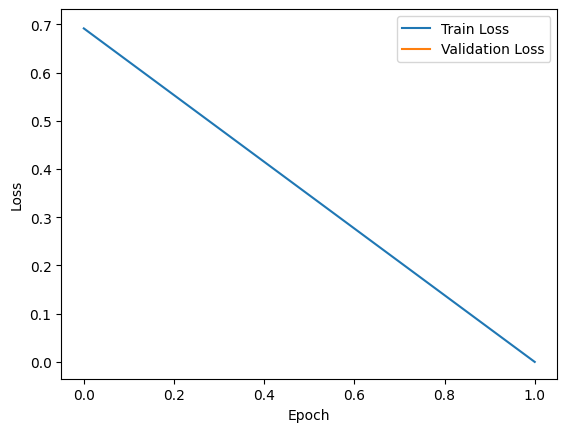

In [ ]:
train_generator = create_dataset(train_images, train_labels, batch_size=32)

# Test verisi üreteci
test_generator = create_dataset(test_images, test_labels, batch_size=32)

history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_images) // 32,  # Number of batches per epoch
    validation_data=test_generator,
    validation_steps=len(test_images) // 32,  # Number of batches per validation
    callbacks=[early_stopping]
)


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_image = Image.open('/content/surface-crack-detection/Positive/00001.jpg')
test_image = test_image.resize((224, 224))
test_image = np.array(test_image) / 255.0


predictions = model.predict(np.expand_dims(test_image, axis=0))

predicted_class = np.argmax(predictions, axis=1)

if predicted_class == 0:
    predict = "Notifected"

else:
   predict = "Infected"

plt.imshow(test_image)
plt.title( predict)
plt.axis('off')
plt.show()
